In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm

from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from matplotlib import pyplot as plt
import itertools

from torchvision.models import vgg16,VGG16_Weights, resnet101,ResNet101_Weights
import torch.nn as nn

In [2]:
#### Config Values ###

IMG_SHAPE = (224,224,3)
BATCH_SIZE = 128
EPOCHS = 40
SHUFFLE = True
SEED = 42
CLASSES =['cats'] # for OC-CNN
CLASSES_T =['unknown','cat','dog'] # for BoN-CNN
CLASSES_B =['wild','cat','dog'] # for Bon test
TRAIN_PATH = r"C:\Users\asiclab06\Datasets\afhq\val"
TEST_PATH = r"C:\Users\asiclab06\Datasets\afhq\train"

In [7]:
## Define Dataset

class ImageDataset(Dataset):
    def __init__(self,root,classes,target_size:tuple,shuffle=False,**kwargs):
        super().__init__()
        self.root=  root
        self.classes = classes
        self.target_size = target_size
        self.shuffle = shuffle        

        self._load_data()
        self._set_index_array()     
        self._set_shuffle()
    
        # kwargs
        self.samples = kwargs.pop('samples',None)
        if self.samples is not None:
            self._sampling_data()

    def _sampling_data(self):
        s = np.random.choice(self.__len__()-self.samples,1).item() if self.shuffle else 0
        e = self.samples
        self.data = self.data[s:e+s]
        self.label = self.label[s:e+s]

    def _load_data(self):
        self.data = []
        self.label = []

        for i,cla in enumerate(self.classes):
            sub_dir = os.path.join(self.root,cla)
            if not os.path.exists(sub_dir):
                print(f'Not found images in "{cla}" directory.')
                continue
            sub_files = os.listdir(sub_dir)
            self.data.extend([os.path.join(sub_dir,sub_file) for sub_file in sub_files])
            l=len(sub_files)
            self.label.extend([i for _ in range(l)])
            print(f'Found {l} images in "{cla}" directory.')

        self.data = np.array(self.data) 
        self.label = np.array(self.label)
        
    def _set_index_array(self):
        self.index_array = np.arange(self.__len__())
        if self.shuffle:
            self.index_array = np.random.permutation(self.__len__())

    def _set_shuffle(self):
        self.data = self.data[self.index_array]
        self.label = self.label[self.index_array]

    def __getitem__(self, index):
        """
            Return : PIL image, sparse label
        """
        x = Image.open(self.data[index]).convert('RGB')
        x = x.resize(self.target_size[:2],Image.Resampling.BILINEAR)
        

        return x, self.label[index]

    def __len__(self):
        return len(self.data)

class FaceClfDataset(ImageDataset):
    def __init__(self, root, classes, target_size: tuple, shuffle=False, transform=None, class_mode=None, **kwargs):
        super().__init__(root, classes, target_size, shuffle, **kwargs)
        # transform
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])

        self.allow_class_modes =  ["categorical","sparse",None]

        if class_mode is not None:
            self.class_mode = class_mode
        else:
            self.class_mode = self.allow_class_modes[0]

    def _class_mode(self,y):
        if self.class_mode == self.allow_class_modes[0]:
            return self._to_categorical_class(y)
        elif self.class_mode == self.allow_class_modes[1]:
            return torch.tensor(y,dtype=torch.long)

    def _to_categorical_class(self,y):
        temp = torch.zeros((len(self.classes),),dtype=torch.long)
        temp[y] = 1
        return temp 

    def categorical2sparse(y:torch.Tensor):
        return torch.argmax(y,1)

    def __getitem__(self, index):
        x,y = super().__getitem__(index)
        return self.transform(x),self._class_mode(y)

    def get_sample(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()    


In [189]:
## train, val set
train_dataset = FaceClfDataset(TRAIN_PATH,CLASSES_T,(IMG_SHAPE),SHUFFLE,class_mode='categorical')
train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

test_dataset = FaceClfDataset(TEST_PATH,CLASSES_B,(IMG_SHAPE),False,class_mode='sparse')
test_loader = DataLoader(test_dataset,BATCH_SIZE,False)


Not found images in "unknown" directory.
Found 500 images in "cat" directory.
Found 500 images in "dog" directory.
Found 4738 images in "wild" directory.
Found 5153 images in "cat" directory.
Found 4739 images in "dog" directory.


In [109]:
## utills 

def wrap_generator(generator):
    while True:
        x,y = next(iter(generator))
        zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
        y = torch.concat([y,zeros], axis=0)
        yield x,y

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
    if cm_proba:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_T): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(os.path.join(base_path, label)))
        img = Image.open(os.path.join(base_path, label) + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_B):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  

class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module,permute = True):
        super().__init__()
        self.model = model
        self.layer_output = []

        def trans(tensor:torch.Tensor):
            try:
                return tensor.permute(0,2,3,1).data.numpy()
            except:
                return tensor.data.numpy()
        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: {output.shape}")
            )
            layer.register_forward_hook(
                lambda layer, input, output: self.layer_output.append([layer.__name__,(trans(output) if permute else output)])
            )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            self.model(x)
        return x

class ConfusionMatrix:
    def __init__(self,classes = None):
        self.cm = None

        if classes is not None:
            self.classes = classes
            self.n_classes = len(classes)

    def get_conf_matrix(self,actual,pred):
        if self.classes is None:
            self.classes = torch.unique(actual)
            self.n_classes = len(self.classes)
        conf_matrix = torch.zeros((self.n_classes, self.n_classes), dtype=torch.int32)
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                conf_matrix[i, j] = torch.sum((actual == self.classes[i]) & (pred == self.classes[j]))

        return conf_matrix

    def update(self,actual,pred):

        curr_cm = self.get_conf_matrix(actual,pred)
        if self.cm is not None:
            self.cm += curr_cm
        else:
            self.cm = curr_cm

    def get_acc(self):
        _sum = 0
        tp = 0
        for i in range(self.n_classes):
            for j in range(self.n_classes):
                _sum += self.cm[i,j]
                if i == j:
                    tp += self.cm[i,j]
        return tp / _sum
        
    def get_result(self):
        return self.cm
    

In [182]:
## models 

def get_vgg16(n_classes,device = torch.device('cuda:0')):
    vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in vgg.parameters():
        param.requires_grad = False

    # clf.add_module(str(clf.__len__()),
    #     nn.Linear(in_features=4096, out_features=n_classes, bias=True))
    clf = nn.Sequential(
        nn.Linear(in_features=4096, out_features=512, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=False),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=False),
    )
    return nn.Sequential(vgg.features,nn.Flatten(),vgg.classifier[:1]).to(device),clf.to(device)

def get_resnet101(n_classes,device = torch.device('cuda:0')):
    resnet = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    for param in resnet.parameters():
        param.requires_grad = False

    clf = nn.Sequential(
        nn.Linear(in_features=2048, out_features=512, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=128, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=n_classes+1, bias=True),
    )
    return nn.Sequential(*[_ for _ in resnet.children()][:-1],nn.Flatten()).to(device),clf.to(device)

class OCCNN(nn.Module):
    def __init__(self,n_classes,backbone:str,device):
        """
        Args: 
            n_classes : trainning classes number. ex. ['cat','dog'] => n_classes = 2
            backbone : current allow model [vgg16, resnet101] 
        """
        super().__init__()
        
        self.device = device
        self.n_classes = n_classes
        self.backbone, self.clf = self._get_backbone(backbone)

        self.inm = nn.InstanceNorm1d(1,affine=False)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(4096)

        if self.device == torch.device('cuda:0'):
            self.cuda()
        else:
            self.cpu()
        
        a = next(self.backbone.parameters()).device
        print(f"Model device: {a}")
    
    def _get_backbone(self,b):
        return eval(f'get_{b}(self.n_classes,"{self.device}")')

    def forward(self,x):
        x = self.backbone(x)
        x = self.relu(self.bn(x))
        
        if self.training:
            unk_vector = torch.normal(0.,0.01,x.shape,device=self.device)
            x = x.view(-1,1,4096)
            x = self.inm(x)
            x = x.view(-1,4096)
            x = torch.vstack([x,unk_vector])
            x = self.relu(x)
        else :
            x = x

        x = self.clf(x)

        return x

    def fit(self,
        train_generator,
        epochs,
        lr,
        device,
        val_generator=None
        ):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adam(self.clf.parameters(),lr=lr)
        
        for ep in range(epochs):
            train_loss = 0.
            self.train()
            i=0
            cm = ConfusionMatrix([0,1,2])
            for x,y in tqdm(train_generator):
                zeros = torch.zeros_like(y) + torch.Tensor([1.,0.,0.]) # add fake label
                y = torch.concat([y,zeros], axis=0)
                x = x.to(device)
                y = y.to(device)

                pred = self.forward(x)
                loss = criterion(pred,y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                cm.update(torch.argmax(y,1),torch.argmax(pred,1))
                train_loss += loss.item()
                i += 1

            print(f"train loss : {train_loss/i} train acc : {cm.get_acc()}")


    def predict(self,test_generator):
        cm = ConfusionMatrix([0,1,2])
        self.eval()
        for x,y in tqdm(test_generator):
            x = x.to(self.device)
            y = y.to(self.device)

            pred = torch.argmax(torch.softmax(self.forward(x),1),1)
            cm.update(y,pred)
            
        return cm.get_result()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
c = OCCNN(2,'vgg16',device)


Model device: cuda:0


In [183]:
## BoN train

# train_dataset = FaceClfDataset(r"data\train",['unkown','cats','dogs'],(IMG_SHAPE),SHUFFLE,class_mode='categorical')
# train_loader = DataLoader(train_dataset,BATCH_SIZE,SHUFFLE)

# test_dataset = FaceClfDataset(r'data\test',['wild','cats','dogs'],(IMG_SHAPE),False,class_mode='sparse')
# test_loader = DataLoader(test_dataset,BATCH_SIZE,False)

c.fit(train_loader,40,1e-4,device)


Not found images in "unkown" directory.
Found 300 images in "cats" directory.
Found 300 images in "dogs" directory.
Found 500 images in "wild" directory.
Found 1000 images in "cats" directory.
Found 1000 images in "dogs" directory.


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


train loss : 0.9835023522377014 train acc : 0.4533333480358124


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


train loss : 0.7484304785728455 train acc : 0.4816666543483734


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


train loss : 0.6321306347846984 train acc : 0.48750001192092896


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


train loss : 0.6009854316711426 train acc : 0.4891666769981384


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


train loss : 0.5923827886581421 train acc : 0.49166667461395264


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


train loss : 0.5796332359313965 train acc : 0.49416667222976685


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5759511947631836 train acc : 0.4950000047683716


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5722543120384216 train acc : 0.49666666984558105


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


train loss : 0.5685847043991089 train acc : 0.49916666746139526


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


train loss : 0.5663611650466919 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


train loss : 0.5644859075546265 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


train loss : 0.5638895273208618 train acc : 0.4983333349227905


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


train loss : 0.5605533719062805 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


train loss : 0.5611753225326538 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5585890293121338 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


train loss : 0.5589175820350647 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5590811014175415 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


train loss : 0.5586901068687439 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


train loss : 0.5560274839401245 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


train loss : 0.5561566352844238 train acc : 0.49916666746139526


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5547445297241211 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5555532455444336 train acc : 0.5


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


train loss : 0.5531968832015991 train acc : 0.5083333253860474


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5548534154891968 train acc : 0.5508333444595337


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


train loss : 0.5516263842582703 train acc : 0.5741666555404663


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


train loss : 0.55311199426651 train acc : 0.5983333587646484


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


train loss : 0.5521330595016479 train acc : 0.7124999761581421


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


train loss : 0.5532480120658875 train acc : 0.7866666913032532


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


train loss : 0.549590003490448 train acc : 0.8366666436195374


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


train loss : 0.549348783493042 train acc : 0.9041666388511658


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


train loss : 0.5482170224189759 train acc : 0.9574999809265137


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


train loss : 0.5480624794960022 train acc : 0.9866666793823242


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


train loss : 0.5471428751945495 train acc : 0.9950000047683716


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


train loss : 0.5458549380302429 train acc : 0.9991666674613953


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


train loss : 0.5463142395019531 train acc : 0.9983333349227905


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


train loss : 0.5446063041687011 train acc : 0.9991666674613953


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


train loss : 0.5446783423423767 train acc : 1.0


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


train loss : 0.5446296811103821 train acc : 1.0


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


train loss : 0.5418364644050598 train acc : 0.9991666674613953


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

train loss : 0.5428922295570373 train acc : 1.0


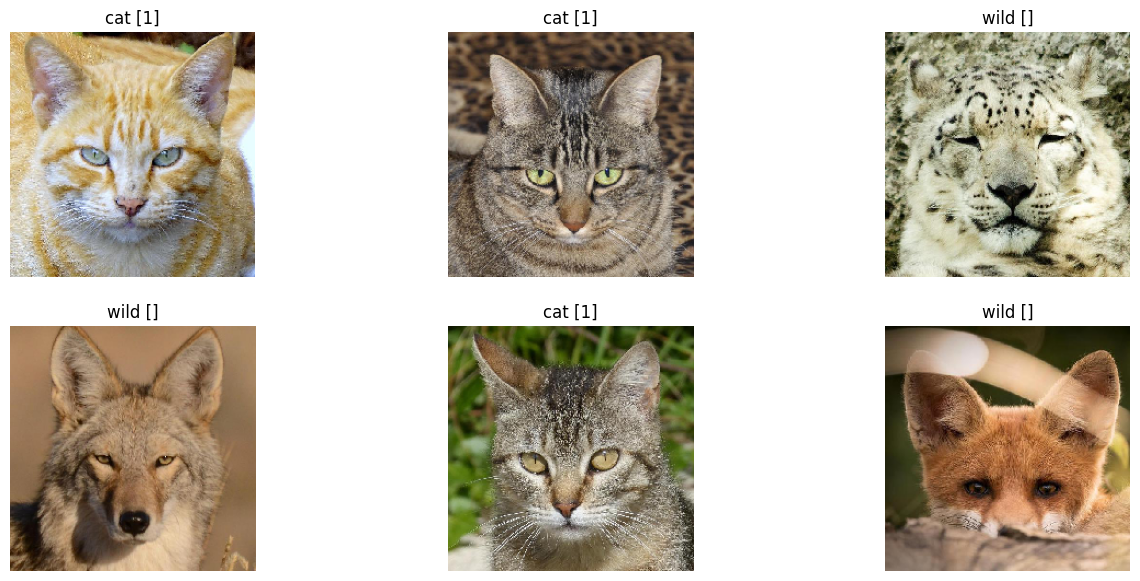

In [184]:
samples = sample_from_derectory()

In [185]:
c.eval()
inp = torch.from_numpy(samples/255)
inp = inp.permute(0,3,1,2).float().to('cuda:0')
inp = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(inp)
preds = torch.softmax(c(inp),1)
preds = torch.argmax(preds,1)
preds

tensor([1, 1, 0, 0, 1, 0], device='cuda:0')

In [190]:
re = c.predict(test_loader)

100%|██████████| 115/115 [01:20<00:00,  1.42it/s]


In [191]:
re

tensor([[3771,  620,  347],
        [  11, 5142,    0],
        [  85,    0, 4654]], dtype=torch.int32)

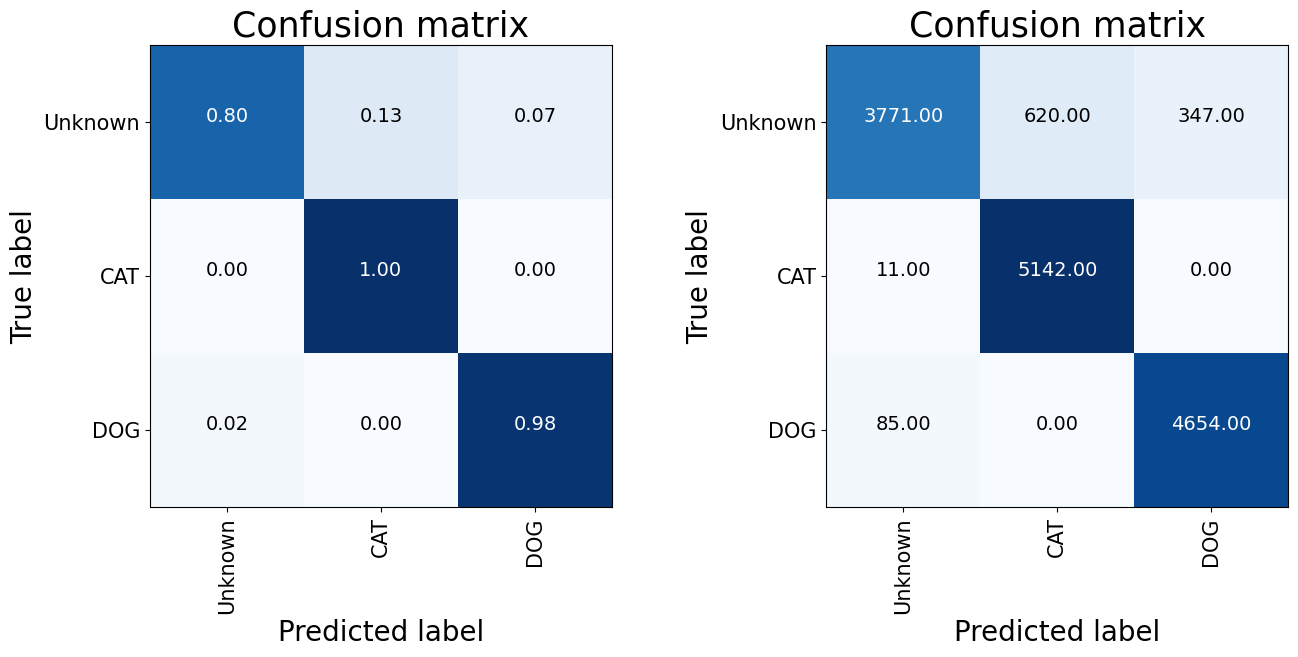

In [192]:
plot_confusion_matrix_detail(re.numpy(), classes=['Unknown','CAT','DOG'])
plt.show()

In [199]:
cm = re.numpy()
target = 2
precision = cm[target,target] / sum(cm[:,target])
recall = cm[target,target] / sum(cm[target,:])
f1 = 2*(1/(1/recall + 1/precision))
f1

0.9556468172484601

In [196]:
3771/(3771+620+347)

0.7959054453355846